In [5]:
# get model
from tqdm import tqdm
import sys
sys.path.append('..')
from model_factory import *


  0%|          | 0/200 [00:00<?, ?it/s]

epoch:  1


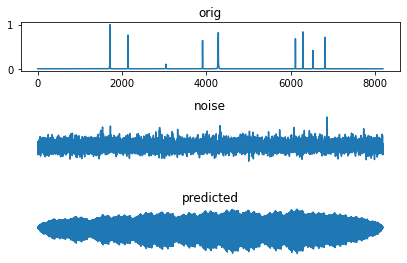

  0%|          | 1/200 [00:12<40:05, 12.09s/it]

val snr increase is:  0.0 loss is  0.0
epoch:  2


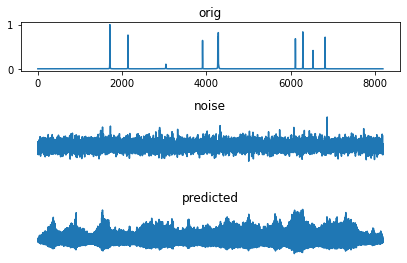

  1%|          | 2/200 [00:23<38:42, 11.73s/it]

val snr increase is:  0.0 loss is  0.0
epoch:  3


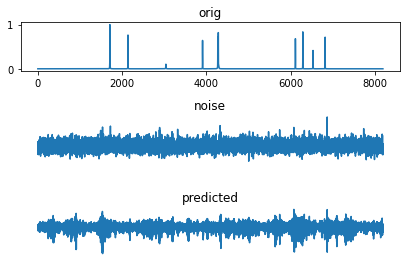

  2%|▏         | 3/200 [00:34<37:17, 11.36s/it]

val snr increase is:  0.0 loss is  0.0
epoch:  4


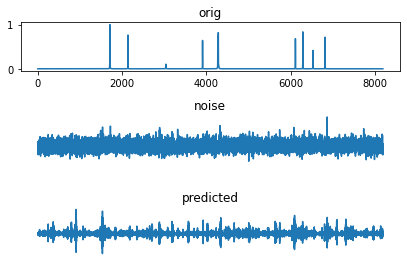

  2%|▏         | 4/200 [00:46<37:25, 11.46s/it]

val snr increase is:  0.0 loss is  0.0
epoch:  5


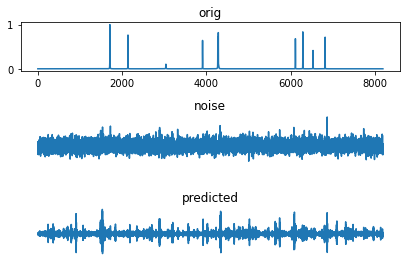

  2%|▎         | 5/200 [00:57<37:24, 11.51s/it]

val snr increase is:  0.0 loss is  0.0
epoch:  6


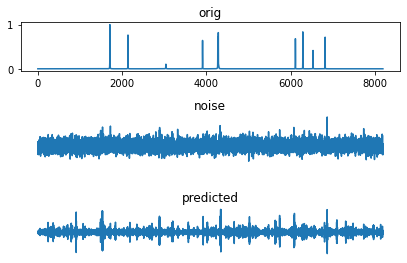

  3%|▎         | 6/200 [01:09<37:42, 11.66s/it]

val snr increase is:  0.0 loss is  0.0
epoch:  7


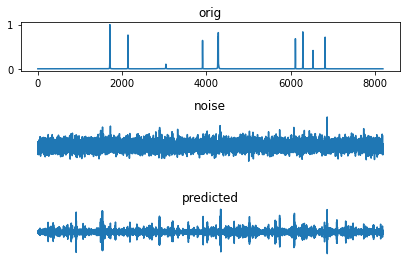

  4%|▎         | 7/200 [01:20<37:05, 11.53s/it]

val snr increase is:  0.0 loss is  0.0
epoch:  8


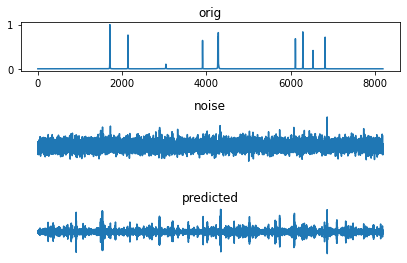

  4%|▍         | 8/200 [01:33<37:58, 11.87s/it]

val snr increase is:  0.0 loss is  0.0
epoch:  9


Exception ignored in: <function _releaseLock at 0x7ff17f19cee0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/logging/__init__.py", line 227, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 


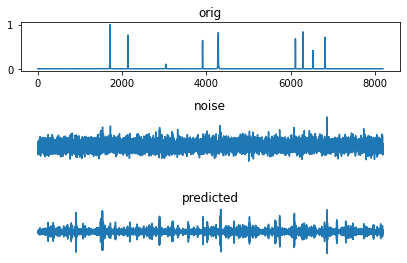

  4%|▍         | 9/200 [01:46<38:27, 12.08s/it]

val snr increase is:  0.0 loss is  0.0
epoch:  10


In [6]:
# make dataset
import os,sys
from glob import glob
import cv2
import torch, copy
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

from tqdm import tqdm
import sys



class One_D_Dataset(Dataset):
    def __init__(self, split="training", config=None):
        
        self.noise = [ os.path.join("/root/autoencoder_denoiser/previous_paper_denoise/gen_dataset/1d", split, f)\
            for f in os.listdir(os.path.join("/root/autoencoder_denoiser/previous_paper_denoise/gen_dataset", "1d", split))]

        split+="_good"
        self.ref = [ os.path.join("/root/autoencoder_denoiser/previous_paper_denoise/gen_dataset/1d", split, f)\
            for f in os.listdir(os.path.join("/root/autoencoder_denoiser/previous_paper_denoise/gen_dataset", "1d", split))]
        

    def __len__(self):
        return len(self.noise)

    def __getitem__(self, i):
        file_index = i//4
        
        y_noise = np.loadtxt(self.noise[file_index])[i-4*file_index]
        y_ref = np.loadtxt(self.ref[file_index])
        return y_ref, y_noise
    


# get model

specs = ( [64, 128, 1024],
        # 1024, 1024, 1024, 512,
        # 512, 512, 512, 512,
        # ], 
        #  [512, 512, 512, 512,
        # 512, 1024, 1024, 1024,
        [ 512, 256, 64])
    
model = UNet_Single(1,1,False,1,channel_specs= None)
model = torch.nn.DataParallel(model).to("cuda")

# config
curr_epoch = 0

epoch = 200
lr = 0.001
lr_step = 5
lr_gamma = 0.01
betas = (0.7, 0.9)
batch=4

optimizer = torch.optim.Adam(model.parameters(),betas=betas ,lr = lr) 
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step, gamma=lr_gamma)
criterion = torch.nn.MSELoss()

shuffle=False
train_loader = DataLoader(One_D_Dataset("training" ), batch_size=batch, shuffle=shuffle, num_workers=os.cpu_count())
val_loader = DataLoader(One_D_Dataset("validation"), batch_size=batch, shuffle=shuffle, num_workers=os.cpu_count())
test_loader = DataLoader(One_D_Dataset("testing"), batch_size=batch, shuffle=shuffle, num_workers=os.cpu_count())

train_losses = 0
val_losses = 0
test_losses = 0
train_snr = 0
val_snr = 0
test_snr  = 0

# SNR helper
def compute_SNR( raw, noisy_img):
        
        signal = torch.mean(torch.abs(raw))
        noise =  torch.mean((noisy_img - raw)**2)
        noise = torch.sqrt(noise)
        return (signal/noise).item()
    
def SNR_increase(raw, noise, prediction):
        orig_SNR = compute_SNR(raw, noise)
        denoised_SNR = compute_SNR(raw, prediction)
        return denoised_SNR/orig_SNR
    



def one_step(mode='train'):
        if mode=='train':
            model.train()
            loader = train_loader
            losses = train_losses
            snr = train_snr
        elif mode=='val':
            model.eval()
            loader = val_loader
            losses = val_losses
            snr = val_snr    
        elif mode == 'test':
            model.eval()
            loader = test_loader
            losses = test_losses
            snr = test_snr
            
        losses = 0
        snr = 0
        # temp
        # Iterate over the data, implement the training function
        for iter, data in enumerate((loader)):
            raw, noise = data
            raw, noise = raw.cuda().float(), noise.cuda().float()
            
       
            prediction = model.forward(noise)

            loss = criterion(prediction,raw )
            
            
                    
            if mode == 'train': 
                loss.backward()
                optimizer.step()
            elif iter == 0:
                # plt.clf()
                ax = plt.subplot(3, 1, 1)
                # plt.tight_layout()
                ax.set_title('orig')
                # ax.axis('off')
                plt.plot(raw[0].cpu())

                ax = plt.subplot(3, 1, 2)
                plt.tight_layout()
                ax.set_title('noise')
                ax.axis('off')
                plt.plot(noise[0].cpu())
                
                ax = plt.subplot(3, 1, 3)
                plt.tight_layout()
                ax.set_title('predicted')
                ax.axis('off')
                plt.plot(prediction[0].detach().cpu())

                plt.show()
                # plt.savefig(os.path.join("/root/autoencoder_denoiser/previous_paper_denoise/oneD_sample", "epoch_{}_val.png".format(str(curr_epoch))))
                break

            losses += loss.item()
            snr += SNR_increase( raw, noise, prediction)
        losses /= (iter+1)
        snr /= (iter+1)
        
        return losses ,snr
    
    
train_loss_list = []
train_snr_list = []
val_loss_list = []
val_snr_list = []

import os
os.makedirs("/root/autoencoder_denoiser/previous_paper_denoise/oneD_sample", exist_ok=True)

for i in tqdm(range(epoch)):  # loop over the dataset multiple times
            curr_epoch+=1
            print("epoch: ", curr_epoch)
            train_loss, train_accu = one_step("train")
            val_loss,val_SNR_increase = one_step("val")
            train_loss_list.append(train_loss)
            val_loss_list.append(val_loss)
            train_snr_list.append(train_accu)
            val_snr_list.append(val_SNR_increase)
            print("val snr increase is: ", val_SNR_increase, "loss is ", val_loss)
            
            lr_scheduler.step()